In [ ]:
import uproot
import awkward as ak
import numpy as np

# Open File

In [ ]:
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37621365._000015.pool.root.1")

## Get to know your data
MC simulation electroweak boson nominal samples from the ATLAS experiment. 

### Exercise 1:

What objects are in this file? What's the name of the ttree?

In [ ]:
file.keys()

In [ ]:
# Access ttree
tree = file["CollectionTree;1"] # fix me

In [ ]:
# we can see the list of branch names using tree.keys()
tree.keys()

In [ ]:
# or you can use tree.show() to see more information on the branches
tree.show()

### Exercise 2

How many branches are in this ttree?
To answer this, you may want to use `len(...)`. 

In [ ]:
x = len(tree) # fix me
print("Number of branches:", x)

### Exercise 3

We can read TBranches as arrays using `tree.arrays(["insert_list_of_branch_names_here"])`. Fill in the blanks associated with Muons (we want charge, pt, eta, phi).

In [ ]:
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
Muons = tree.arrays(["AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"]) # fix me

### Exercise 4
How many events are in this tree?

In [ ]:
num_events = len(Muons) # fix me
print("Number of events:", num_events)

### Exercise 5

How many electrons are in the 80th event? What are their charges? How many muons are in the 34th event? What are their pt? 

In [ ]:
Electrons["AnalysisElectronsAuxDyn.charge"][79]

In [ ]:
Muons["AnalysisMuonsAuxDyn.pt"][33] # fix me

To make our lives easier, [ak.zip](https://awkward-array.org/doc/main/reference/generated/ak.zip.html) combines arrays into a single structure as a collection of records. 

In [ ]:
e = ak.zip({
    "pt" : Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta" : Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi" : Electrons["AnalysisElectronsAuxDyn.phi"],
    "mass" : Electrons["AnalysisElectronsAuxDyn.m"],
    "charge" : Electrons["AnalysisElectronsAuxDyn.charge"]
})
mu = ak.zip({
    "pt" : Muons["AnalysisMuonsAuxDyn.pt"],
    "eta" : Muons["AnalysisMuonsAuxDyn.eta"],
    "phi" : Muons["AnalysisMuonsAuxDyn.phi"],
    "charge" : Muons["AnalysisMuonsAuxDyn.charge"]
})

What's the total number of electrons in the data set? What about muons? The function [ak.num](https://awkward-array.org/doc/main/reference/generated/ak.num.html) may help.

In [ ]:
num_e = ak.sum(ak.num(e.charge)) # fix me
num_mu = ak.sum(ak.num(mu.charge)) # fix me 
print("Total number of electrons: ", num_e)
print("Total number of muons: ", num_mu)

# Ready for analysis

Now we are going to calculate the tranverse momentum components and energy for electrons, using the above.  

In [ ]:
#  Momentum components
def Px(pt, phi):
    return pt*np.cos(phi)

def Py(pt,phi):
    return pt*np.sin(phi)

def Pz(pt,eta):
    return pt*np.sinh(eta)

def E(pt, eta, m):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + m**2)

e_px = Px(e.pt,e.phi)
e_py = Py(e.pt,e.phi)
e_pz = Pz(e.pt,e.eta)
e_E = E(e.pt,e.eta,e.mass)

The invariant mass of two oppositely charged leptons is defined as:
\begin{equation}
m_0 = \sqrt{(\sum{E})^2-(\sum{p_x})^2-(\sum{p_y})^2-(\sum{p_z})^2}
\end{equation}


### Exercise 6

Create a function, using the functions above for energy and momentum components, that calculates the invariant mass in GeV. Calculate the invariant mass of the electron pair in the 63rd event.

In [ ]:
def calc_invm(p1, p2):
    sumpx = Px(p1.pt, p1.phi) + Px(p2.pt, p2.phi) # fix me
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt, p2.phi) # fix me
    sumpz = Pz(p1.pt, p1.phi) + Pz(p2.pt, p2.phi) # fix me 
    sumE = E(p1.pt, p1.phi) + E(p2.pt, p2.phi) # fix me
    
    invm = np.sqrt((sumE)^2 - (sumPx)^2 - (sumPy)^2 - (sumPz)^2) # fix me
    return invm/1000.0 # in GeV

In [ ]:
e[62][0].pt

## Data Selection

As shown in Frank's workshop, we can mask awkward arrays to apply cuts for data selection. 

### Exercise 7

Make a selection of events with more than two electrons and with electron pt greater than 25 GeV [data set is in MeV].

This should leave you with a total of 2130 electrons.

In [ ]:
e_cut = (e.pt>25000) & (ak.num(e.charge >= 2))
cleaned_e = e[e_cut]
# check 
filtered_electrons = ak.sum(ak.num(cleaned_e))
print("Number of electrons that passed selection:", filtered_electrons)

### Exercise 8

Of these events, we want to calculate the invariant mass of oppositely charged pairs. However, some events include 3 electrons perhaps with charges [1,-1,1], which in this case have 2 possible pairings. 

How many events contain more than 2 electrons? What are their indices?

The function [ak.where](https://awkward-array.org/doc/main/reference/generated/ak.where.html) and [ak.combinations](https://awkward-array.org/doc/main/reference/generated/ak.combinations.html) may come in handy.

In [ ]:
lengths = ak.num(cleaned_e)
indices = ak.where(lengths > 2)[0].tolist()
indices

In [ ]:
cleaned_e[15180]

In [ ]:
h = ak.combinations(cleaned_e, 2, axis = 1)
h[15180]

# Homework Assignment

## Problem 1
Continuing on with the workshop, the goal of this assignment is to plot the Z mass using the tools we've learned from the awkward library. Z decays into electron-positron or muon-antimuon. 
<div style="display: flex;">
    <img src="https://atlas.physicsmasterclasses.org/zpath_files/img/highslide/feynman/Z_ElectronPositron.png" style="height:300px; margin-right: 10px;">
    <img src="https://atlas.physicsmasterclasses.org/zpath_files/img/highslide/feynman/Z_MyonAntimyon.png" style="height:300px;">
</div>

1. Create a function `selection_calc(lepton)` that applies the selection we've made above, obtains oppositely charged lepton pairs, and calculates the invariant mass. We want events with oppositely charged lepton pairs with pt > 25 GeV. \
    __hint__: Re-use the functions already built in class. \
    __note__: The data does not contain Muon mass, so you can assume all muons have mass = 0 (you might need to adjust the function `calc_invm` for this) 
   
2. Plot the invariant mass of both electron and muon pairs on the same histogram. Find the peak of the histogram and return the Z mass.

In [1]:
# Importing necessary libraries 
import uproot
import awkward as ak
import numpy as np

In [2]:
# Loading root file with trees 
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37621365._000015.pool.root.1")

In [3]:
# Access ttree
tree = file["CollectionTree;1"] 

In [4]:
# Instantiating electrons and muons and keeping their informations 
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
Muons = tree.arrays(["AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"]) # fix me

In [5]:
# Zipping e^- and muon information then concatenating them for analysis 
e = ak.zip({
    "pt" : Electrons["AnalysisElectronsAuxDyn.pt"],
    "eta" : Electrons["AnalysisElectronsAuxDyn.eta"],
    "phi" : Electrons["AnalysisElectronsAuxDyn.phi"],
    "mass" : Electrons["AnalysisElectronsAuxDyn.m"],
    "charge" : Electrons["AnalysisElectronsAuxDyn.charge"]
})
mu = ak.zip({
    "pt" : Muons["AnalysisMuonsAuxDyn.pt"],
    "eta" : Muons["AnalysisMuonsAuxDyn.eta"],
    "phi" : Muons["AnalysisMuonsAuxDyn.phi"],
    "charge" : Muons["AnalysisMuonsAuxDyn.charge"]
})

# Concatenating electrons and muons into one array called leptons
leptons = ak.concatenate([e, mu], axis=1)


In [6]:
# Invariant mass calculation and selection application

def Px(pt, phi):
    return pt * np.cos(phi)

def Py(pt, phi):
    return pt * np.sin(phi)

def Pz(pt, eta):
    return pt * np.sinh(eta)

def E(pt, eta, mass=0):
    return np.sqrt(pt**2 + (pt * np.sinh(eta))**2 + mass**2)

def calc_invm(p1, p2):
    sumpx = Px(p1.pt, p1.phi) + Px(p2.pt, p2.phi)
    sumpy = Py(p1.pt, p1.phi) + Py(p2.pt, p2.phi)
    sumpz = Pz(p1.pt, p1.eta) + Pz(p2.pt, p2.eta)
    sumE = E(p1.pt, p1.eta, getattr(p1, 'mass', 0)) + E(p2.pt, p2.eta, getattr(p2, 'mass', 0))
    return np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2) / 1000.0  # Convert to GeV

def selection_calc(lepton):
    lepton_cut = lepton.pt > 25000  # pt > 25 GeV in MeV scale
    selected_leptons = lepton[lepton_cut]

    # Obtain oppositely charged lepton pairs
    pairs = ak.combinations(selected_leptons, 2, fields=['p1', 'p2'])
    opp_charge_pairs = pairs[(pairs.p1.charge * pairs.p2.charge) < 0]

    # Calculate invariant mass
    invm = calc_invm(opp_charge_pairs.p1, opp_charge_pairs.p2)
    return invm

# Calculate invariant masses for selected leptons
invm_values = selection_calc(leptons)


/home/hshaddix/.conda/envs/columnar_env/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


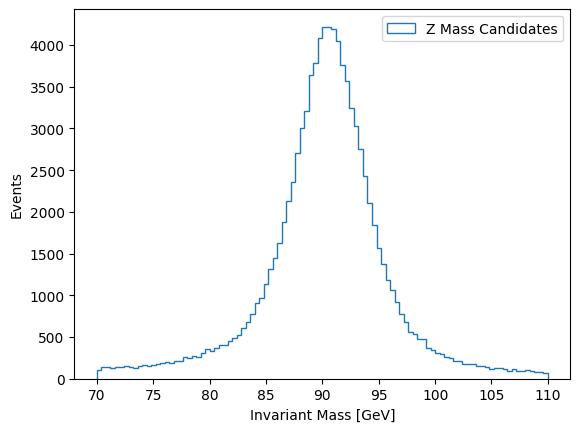

Estimated Z mass peak: 88.43 GeV


In [7]:
# Graphing/ Plotting 
import matplotlib.pyplot as plt
# Flatten the array to handle variable-length data correctly
invm_values_flat = ak.to_numpy(ak.flatten(invm_values))

# Plotting the Z mass
plt.hist(invm_values_flat, bins=100, range=(70, 110), histtype='step', label='Z Mass Candidates')
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()

# Finding the peak (Z mass)
z_mass_peak = invm_values_flat[np.argmax(np.histogram(invm_values_flat, bins=100, range=(70, 110))[0])]
print(f"Estimated Z mass peak: {z_mass_peak:.2f} GeV")


## Problem 2

Now you're on your own! We will make selections used for top quark mass calculation, using ATLAS ttbar mc sample, `/lstr/sahara/act/data/DAOD_PHYSLITE.37620644._000012.pool.root.1`.

1. Make a selection of events that have atleast one lepton with pt > 30GeV and abs(eta) < 2.1 , and at least four jets. The jets should also have pt >25 GeV and abs(eta) < 2.4. How many events were selected? Plot distribution plots to check selection.
 
2. Now let's check jet quality. The btag discriminant is defined as :
   \begin{equation}
   D_{DL1} = \log(\frac{p_b}{f_c \cdot p_c + (1-f_c) \cdot p_u})
   \end{equation}
   where $p_b, p_c, p_u$ are the fields labeled `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu`, and $f_c = 0.018$. Calculate the Btag discriminant of the selected jets.

3. A jet is considered as b-tagged if the $D_{DL1}$ variable is above threshold. The threshold value for 77% efficiency is `2.456`. Make another selection of events that have at least two b-tagged jets. How many events were selected? Plot distribution plots to check selection.

__Hint__: [ak.any(...)](https://awkward-array.org/doc/main/reference/generated/ak.any.html) can help.

In [10]:
# Importing necessary libraries 
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Loading root file with trees 
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37620644._000012.pool.root.1")

# Loading data for leptons and jets
leptons = file['CollectionTree'].arrays([
    "AnalysisElectronsAuxDyn.pt", "AnalysisElectronsAuxDyn.eta", 
    "AnalysisMuonsAuxDyn.pt", "AnalysisMuonsAuxDyn.eta"
], how='zip')
jets = file['CollectionTree'].arrays([
    "AnalysisJetsAuxDyn.pt", "AnalysisJetsAuxDyn.eta",
    "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb", 
    "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc", 
    "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu"
], how='zip')


In [12]:
print(leptons['AnalysisElectronsAuxDyn'].fields)
print(leptons['AnalysisMuonsAuxDyn'].fields)
print(jets['jagged0'].fields)



['pt', 'eta']
['pt', 'eta']
['AnalysisJetsAuxDyn.pt', 'AnalysisJetsAuxDyn.eta', 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb', 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc', 'BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu']


In [15]:
# Lepton selection: pt > 30 GeV and |eta| < 2.1
selected_electrons = leptons['AnalysisElectronsAuxDyn'][
    (leptons['AnalysisElectronsAuxDyn']['pt'] > 30000) &
    (abs(leptons['AnalysisElectronsAuxDyn']['eta']) < 2.1)
]

selected_muons = leptons['AnalysisMuonsAuxDyn'][
    (leptons['AnalysisMuonsAuxDyn']['pt'] > 30000) &
    (abs(leptons['AnalysisMuonsAuxDyn']['eta']) < 2.1)
]

# Combine selected leptons
selected_leptons = ak.concatenate([selected_electrons, selected_muons], axis=1)

# Jet selection: pt > 25 GeV and |eta| < 2.4
selected_jets = jets['jagged0'][
    (jets['jagged0']['AnalysisJetsAuxDyn.pt'] > 25000) &
    (abs(jets['jagged0']['AnalysisJetsAuxDyn.eta']) < 2.4)
]

# Event selection: at least one lepton and at least four jets
event_cut = (ak.num(selected_leptons['pt']) >= 1) & (ak.num(selected_jets['AnalysisJetsAuxDyn.pt']) >= 4)
selected_events = selected_jets[event_cut]

print(f"Number of selected events: {ak.sum(event_cut)}")

Number of selected events: 49301


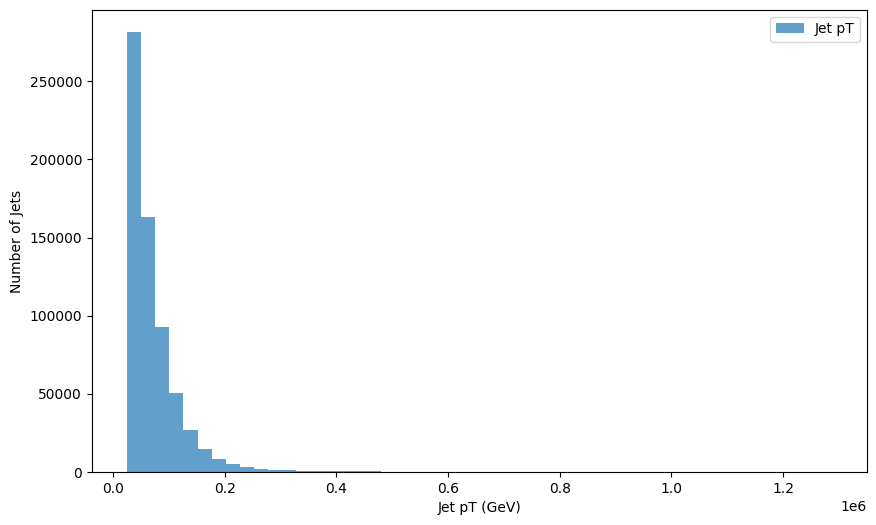

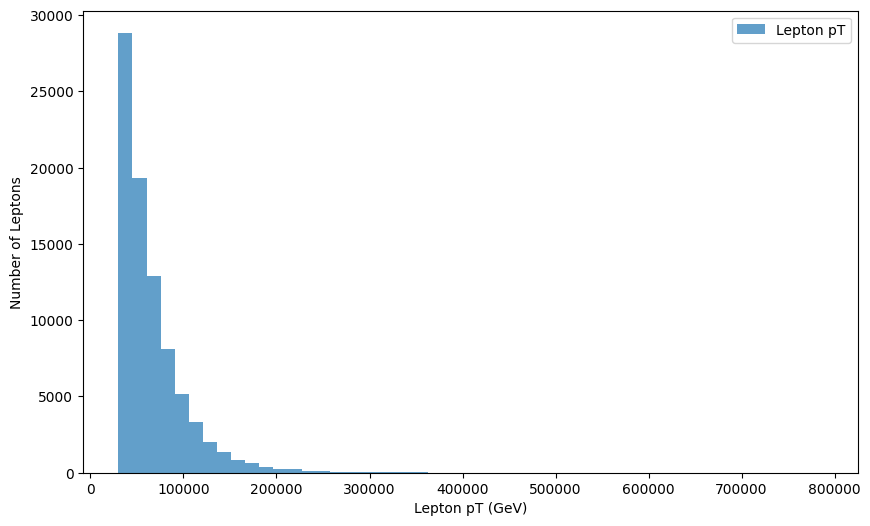

In [17]:
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(ak.flatten(selected_jets['AnalysisJetsAuxDyn.pt'], axis=None), bins=50, alpha=0.7, label="Jet pT")
plt.xlabel('Jet pT (GeV)')
plt.ylabel('Number of Jets')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(ak.flatten(selected_leptons['pt'], axis=None), bins=50, alpha=0.7, label="Lepton pT")
plt.xlabel('Lepton pT (GeV)')
plt.ylabel('Number of Leptons')
plt.legend()
plt.show()

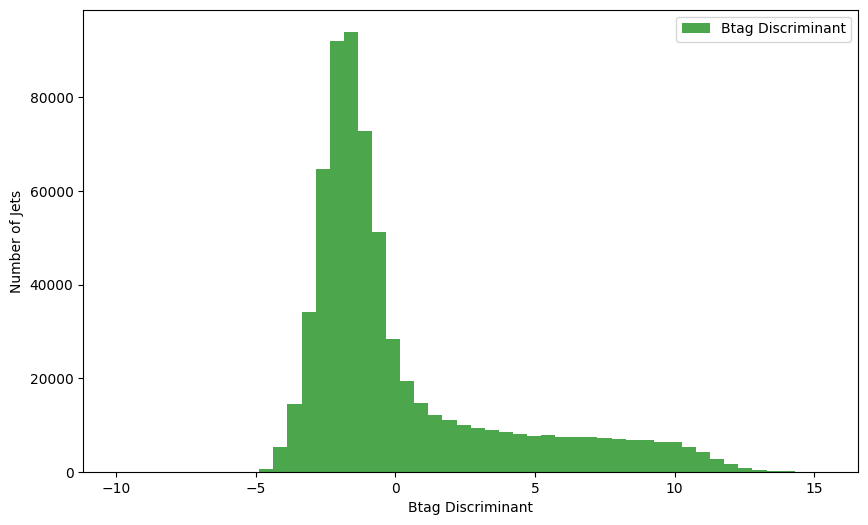

In [19]:
# Btag descriminant calculation 

# Extract btagging probabilities
pb = selected_jets['BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb']
pc = selected_jets['BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc']
pu = selected_jets['BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu']

# Calculate btag discriminant
btag_discriminant = np.log(pb / (0.08 * pu + 0.92 * pc))

# Plotting the btag discriminant
plt.figure(figsize=(10, 6))
plt.hist(ak.flatten(btag_discriminant, axis=None), bins=50, alpha=0.7, color='green', label='Btag Discriminant')
plt.xlabel('Btag Discriminant')
plt.ylabel('Number of Jets')
plt.legend()
plt.show()


Number of events with at least two b-tagged jets: 28105


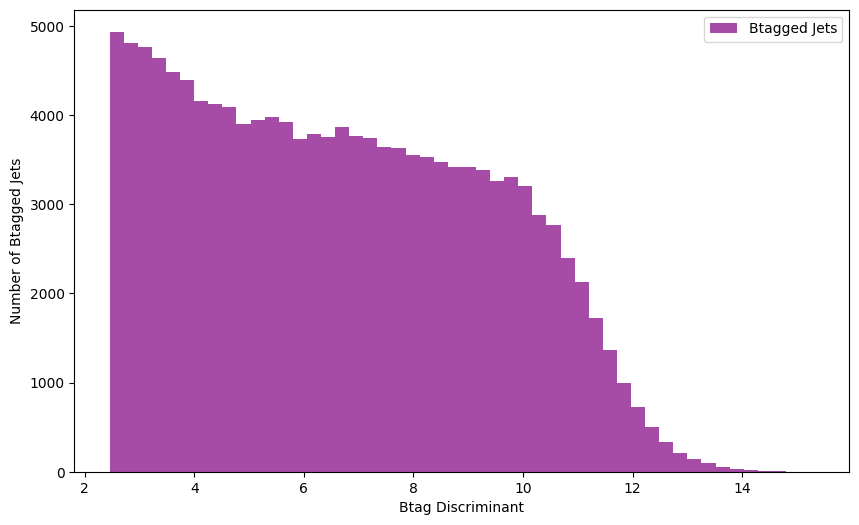

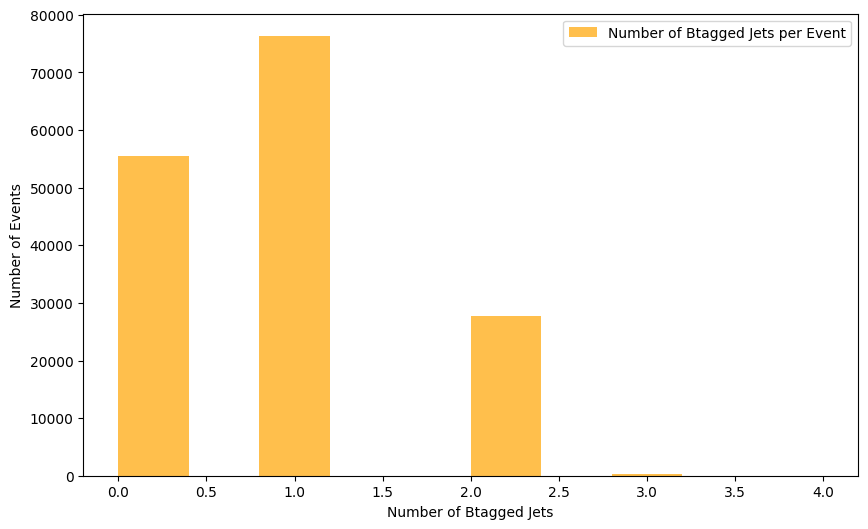

In [20]:
# Making selections for Btag desriminant 

# B-tag threshold for 77% efficiency
btag_threshold = 2.456

# Identify b-tagged jets
btagged_jets = btag_discriminant > btag_threshold

# Select events with at least two b-tagged jets
event_cut_btag = ak.sum(btagged_jets, axis=1) >= 2
selected_events_btag = selected_jets[event_cut_btag]

# Print the number of selected events
print(f"Number of events with at least two b-tagged jets: {ak.sum(event_cut_btag)}")

# Plotting b-tag discriminant distribution for selected events
plt.figure(figsize=(10, 6))
plt.hist(ak.flatten(btag_discriminant[btagged_jets], axis=None), bins=50, alpha=0.7, color='purple', label='Btagged Jets')
plt.xlabel('Btag Discriminant')
plt.ylabel('Number of Btagged Jets')
plt.legend()
plt.show()

# Optional: Plot the number of b-tagged jets per event
plt.figure(figsize=(10, 6))
plt.hist(ak.sum(btagged_jets, axis=1), bins=10, alpha=0.7, color='orange', label='Number of Btagged Jets per Event')
plt.xlabel('Number of Btagged Jets')
plt.ylabel('Number of Events')
plt.legend()
plt.show()


## Problem 3

Using the provided ttbar sample from CMS,`/lstr/sahara/act/data/TTto2L2Nu_NanoAODv12-130x_mcRun3_13p6TeV_powheg-pythia.root`, calculate the efficiency of the HLT_Mu8 trigger for events with 1 muon as a function of muon pT. At what muon pT does the trigger 'turn on'? Can you guess what the trigger name means? Do this again, but for events with 2 muons. Explain any similarities/differences as they relate to the trigger.You may use coffea or uproot as your entry point into the file. \
__Note:__ The efficiency of a trigger is defined as the ratio of the number of events passing the trigger (HLT_Mu8 = True) to all events. This is often done for individual bins of some quantity. Histogram objects from the Hist package can be divided.

In [22]:
# Importing some libraries
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Load the ROOT file
file = uproot.open("/lstr/sahara/act/data/TTto2L2Nu_NanoAODv12-130x_mcRun3_13p6TeV_powheg-pythia.root")

# Load relevant branches
events = file['Events'].arrays([
    'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass',
    'HLT_Mu8'  # Trigger flag
], how='zip')

In [25]:
print(events.fields)
print(events['Muon'].fields)  # Inspect the nested 'Muon' branch


['HLT_Mu8', 'Muon']
['pt', 'eta', 'phi', 'mass']


In [28]:
# Select events with at least one or two muons
one_muon_events = events[ak.num(events['Muon']['pt']) == 1]
two_muon_events = events[ak.num(events['Muon']['pt']) == 2]

# Extract muon pT and HLT_Mu8 trigger flag
one_muon_pt = ak.flatten(one_muon_events['Muon']['pt'])
one_muon_trigger = one_muon_events['HLT_Mu8']

two_muon_pt = ak.flatten(two_muon_events['Muon']['pt'])
two_muon_trigger = two_muon_events['HLT_Mu8']


In [29]:
# Efficiency Calculation
pt_bins = np.linspace(0, 100, 20)

# Efficiency for 1-muon events
efficiency_1muon, _ = np.histogram(one_muon_pt[one_muon_trigger], bins=pt_bins)
total_1muon, _ = np.histogram(one_muon_pt, bins=pt_bins)
efficiency_1muon_ratio = efficiency_1muon / total_1muon

# Efficiency for 2-muon events
efficiency_2muon, _ = np.histogram(two_muon_pt[two_muon_trigger], bins=pt_bins)
total_2muon, _ = np.histogram(two_muon_pt, bins=pt_bins)
efficiency_2muon_ratio = efficiency_2muon / total_2muon


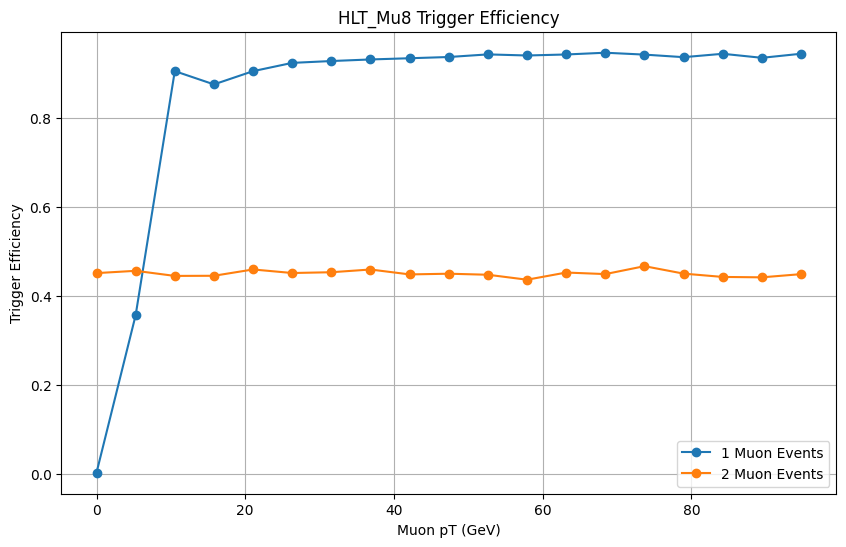

In [30]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pt_bins[:-1], efficiency_1muon_ratio, label='1 Muon Events', marker='o')
plt.plot(pt_bins[:-1], efficiency_2muon_ratio, label='2 Muon Events', marker='o')
plt.xlabel('Muon pT (GeV)')
plt.ylabel('Trigger Efficiency')
plt.title('HLT_Mu8 Trigger Efficiency')
plt.legend()
plt.grid(True)
plt.show()